### Import Libraries

In [41]:
import numpy as np
import glob, os
import pandas as pd
import inflect
import re
import time
# next we can import some sklearn libraries to start working with stuff
## transformers and pipline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
## model selectors
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
## models
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
## feature extractors
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from average_word_length_extractor import AverageWordLengthExtractor
from question_extractor import QuestionExtractor
from int_to_words_extractor import NumberStringExtractor
from greeting_extractor import GreetingExtractor
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from text_preprocessor import TextPreprocessor
from sentiment_extractor import SentimentExtractor
from ner_extractor import NERExtractor
# model testing
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix 
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, brier_score_loss, recall_score, precision_score
from sklearn.utils.fixes import signature
# save model
from sklearn.externals import joblib
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Reading test data

In [3]:
test_files = glob.glob('../data/data_v1/TestCSV_Updated/*.csv')
test = pd.concat([pd.read_csv(fp).assign(test_set=re.split('_|, ',os.path.basename(fp))[0]) for fp in test_files])

In [4]:
test.head(3)

,stringList,speakerID,semanticType,leading,Symptom,PMH,MEDS,ALLG,FAMHx,lifestyle,...,GS4089,GS4090,GS4091,GS4092,GS4093,GS4094,GS4095,stringedQuestion,supportProvision,test_set
0,so I was wondering if you could tell me why yo...,doctor,openQuestion,no,no,no,no,no,no,no,...,0.122049,-0.030231,-0.014938,0.023475,-0.004900,-0.003502,0.034194,no,no,10
1,okay,patient,statement,no,no,no,no,no,no,no,...,0.081148,-0.030529,0.009020,0.026534,0.000665,0.012509,0.008983,no,no,10
2,um I lost like 15 pounds just really quickly i...,patient,statement,no,yes,no,no,no,no,no,...,0.042242,0.010893,0.018835,-0.019626,0.010086,0.002141,0.082543,no,no,10


In [5]:
# convert yes to True(1) and no to False(0)
test = test.replace(to_replace={'yes': 1, 'no': 0})

In [6]:
# remove test_set columns
test.drop(['test_set'], axis = 1, inplace=True)

In [7]:
# features over which we have to predict
prediction_columns = ['stringedQuestion',
                   'leading', 'Symptom', 'PMH', 'MEDS', 'ALLG', 'FAMHx', 'lifestyle',
                   'pysch', 'SOCHx', 'sexualHistory', 'substanceUse', 'PE', 'FORM',
                   'supportProvision', 'transition']

In [8]:
# extract doctor interactions
test = test.loc[test.speakerID == 'doctor']

### Feature Selection

In [9]:
# select columns by data
X_test = test.drop(prediction_columns, axis=1)
unusable_columns = ['speakerID', 'case_ID']
X_test = X_test.drop(unusable_columns, axis=1)
# select x and y
y_test = test.loc[:, test.columns == prediction_columns[8]]

In [10]:
# drop nas for now
X_test.dropna(inplace=True, axis = 1)

In [11]:
# check the balance for each prediction feature
for n,i in enumerate(prediction_columns):
    balance = test.loc[:, test.columns == prediction_columns[n]][i].value_counts()[1] / y_test.shape[0]
    print('%s: %0.3f%%'%(i, balance*100))

stringedQuestion: 2.687%
leading: 0.258%
Symptom: 24.651%
PMH: 4.961%
MEDS: 1.240%
ALLG: 0.724%
FAMHx: 3.669%
lifestyle: 1.964%
pysch: 2.532%
SOCHx: 2.842%
sexualHistory: 0.207%
substanceUse: 2.377%
PE: 10.853%
FORM: 12.196%
supportProvision: 2.274%
transition: 6.873%


### Import model

In [12]:
file_name = '20190406-163309-LightGBM-no-search.pkl'
ml_pipeline = joblib.load('../model/' + file_name)

In [13]:
# get predictions
probs = ml_pipeline.predict_proba(X_test)
preds = probs[:,1]
y_pred = ml_pipeline.predict(X_test)

In [15]:
print("Classification report for classifier %s:\n%s\n"
      % (file_name, classification_report(y_test, y_pred)))

Classification report for classifier 20190406-163309-LightGBM-no-search.pkl:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1886
           1       0.96      0.49      0.65        49

   micro avg       0.99      0.99      0.99      1935
   macro avg       0.97      0.74      0.82      1935
weighted avg       0.99      0.99      0.98      1935




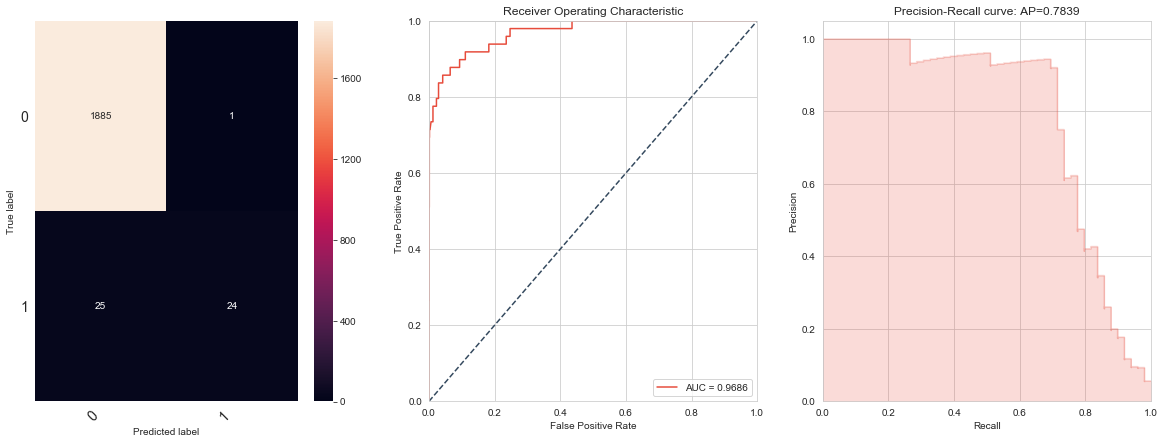

In [19]:
fig = plt.figure(figsize=(20, 7))

# confusion matrix
plt.subplot(1, 3, 1)
df_cm = pd.DataFrame(
    confusion_matrix(y_test, y_pred), 
    index=[0, 1], 
    columns=[0, 1], 
)
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# roc curve
plt.subplot(1, 3, 2)
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, '#e74c3c', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color = '#34495e')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# p-r curve
plt.subplot(1, 3, 3)
average_precision = average_precision_score(y_test, preds)
precision, recall, _ = precision_recall_curve(y_test, preds)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='#e74c3c', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='#e74c3c', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.4f}'.format(
          average_precision))

plt.show()

### Save model performance to log

In [63]:
log = pd.read_csv('../results/log.csv')

f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
brier_score = brier_score_loss(y_test, y_pred)

log = log.append(pd.Series([file_name, '../model/' + file_name, accuracy, f1, recall, precision, roc_auc, average_precision, brier_score], index=log.columns), ignore_index=True)

log.to_csv('../results/log.csv', index=False)